## 문제 정의
1. $Q_t(a)=\mathbb E[R_n|A_n=a]$: time step $n$에서 선택된 행동 $a$에 대한 보상 $R_t$의 기댓값
- 이러한 행동 가치 추정값이 수렴하도록 모델 학습
- 기본 확률 분포: Gaussian 분포 (정규분포) => 충분한 샘플이 주어진다면 선택된 행동의 평균으로 수렴될 것으로 예상


2. $A_n=max_a(Q_n(a))$ => greedy action

3. 점증적 구현 (incremental Implimentation): 새롭게 추가된 보상의 관측값만을 사용하여 $Q_n$ 업데이트

    $Q_{n+1}=Q_n+\frac{1}{n}[R_n-Q_n]$

[*Code Reference](https://www.datahubbs.com/multi_armed_bandits_reinforcement_learning_1/)

## $\epsilon$-Greedy Methods
- ϵ의 확률로 어떤 행동을 무작위로 선택, 1-ϵ의 확률로 $Q_t(a)$ 값이 최대가 되게하는 행동을 greedy하게 선택

### Building a greedy k-Armed Bandit

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [4]:
class eps_bandit:
    '''
    epsilon-greedy k-bandit problem
    
    Inputs
    =====================================================
    k: number of arms (int)
    eps: probability of random action 0 < eps < 1 (float)
    iters: number of steps (int)
    mu: set the average rewards for each of the k-arms.
        Set to "random" for the rewards to be selected from
        a normal distribution with mean = 0. 
        Set to "sequence" for the means to be ordered from 
        0 to k-1.
        Pass a list or array of length = k for user-defined
        values.
    '''
    
    def __init__(self, k, eps, iters, mu="random"):
        # Number of arms
        self.k = k
        # Search probability
        self.eps = eps
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 0
        # Step count for each arm
        self.k_n = np.zeros(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)
        
        if type(mu) == list or type(mu).__module__ == np.__name__:
            # USer-difined averages
            self.mu = np.array(mu)
        elif mu == 'random':
            # Draw means from probability distribution
            self.mu = np.random.normal(0, 1, k) # 평균=0, 분산=1인 정규분포에서 k개의 값 생성
        elif mu == 'sequence':
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k-1, k)
        
    def pull(self):
        # Generate random number
        p = np.random.rand() # 0~1 사이의 난수 
        if self.eps == 0 and self.n == 0:
            a = np.random.choice(self.k) 
        elif p < self.eps:
            # Randomly select an action
            a = np.random.choice(self.k)
        else:
            # Take greedy action
            a = np.argmax(self.k_reward) # k번째 arm이 많이 선택될수록 k번째 arm의 reward (self.k_reward[a]) 도 큰 값으로 계속 업데이트 -> 이 arm을 greedy하게 선택
        
        reward = np.random.normal(self.mu[a], 1) # 평균=self.mu[a], 분산=1인 정규분포에서 reward 생성
        
        # Update counts
        self.n += 1
        self.k_n[a] += 1
        
        # Update total -> 점증적 구현 공식
        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.n
        
        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (reward - self.k_reward[a]) / self.k_n[a]
        
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward # iter 반복할 때마다 그때의 평균 보상 저장
            
    def reset(self):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(k)
        

In [5]:
# 서로 다른 epsilon 값으로 결과를 비교해보자
# 1000번의 episode, 각 episode 당 1000번 iteration -> 각 epsisode가 끝날때마다 reset, 일관성 유지 위해 다른 bandits의 평균을 복사

k = 10 # 10개의 arm
iters = 1000

eps_0_rewards = np.zeros(iters)
eps_01_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)

episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    eps_0 = eps_bandit(k, 0, iters) # mu="random"
    eps_01 = eps_bandit(k, 0.01, iters, eps_0.mu.copy())
    eps_1 = eps_bandit(k, 0.1, iters, eps_0.mu.copy())
    
    # Run experiments
    eps_0.run()
    eps_01.run()
    eps_1.run()
    
    # Update long-term averages
    eps_0_rewards = eps_0_rewards + (eps_0.reward - eps_0_rewards) / (i + 1)
    eps_01_rewards = eps_01_rewards + (eps_01.reward - eps_01_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (eps_1.reward - eps_1_rewards) / (i + 1)
    

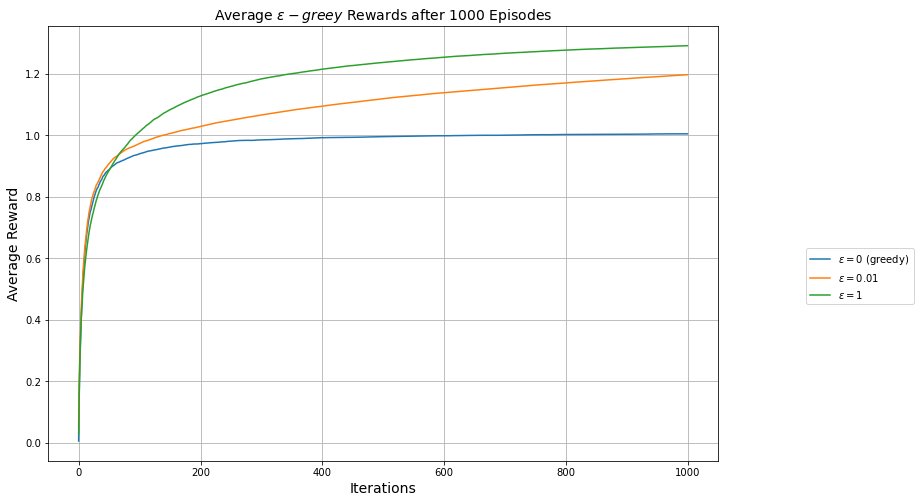

In [12]:
plt.figure(figsize=(12,8))
plt.plot(eps_0_rewards, label='$\epsilon=0$ (greedy)')
plt.plot(eps_01_rewards, label='$\epsilon=0.01$')
plt.plot(eps_1_rewards, label='$\epsilon=1$')
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Average Reward", fontsize=14)
plt.title("Average $\epsilon-greey$ Rewards after " + str(episodes) + " Episodes", fontsize=14)
plt.grid()
plt.show()

$\epsilon=1$이 가장 좋은 성능

In [30]:
# 'sequence' 를 사용해보자

k = 10
iters = 1000

eps_0_rewards = np.zeros(iters)
eps_01_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)
eps_0_selection = np.zeros(k)
eps_01_selection = np.zeros(k)
eps_1_selection = np.zeros(k)

episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    eps_0 = eps_bandit(k, 0, iters, mu='sequence')
    eps_01 = eps_bandit(k, 0.01, iters, eps_0.mu.copy())
    eps_1 = eps_bandit(k, 0.1, iters, eps_0.mu.copy())
    
    # Run experiments
    eps_0.run()
    eps_01.run()
    eps_1.run()
    
    # Update long-term averages
    eps_0_rewards = eps_0_rewards + (eps_0.reward - eps_0_rewards) / (i + 1)
    eps_01_rewards = eps_01_rewards + (eps_01.reward - eps_01_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (eps_1.reward - eps_1_rewards) / (i + 1)
    
    # Average actions per episode
    eps_0_selection = eps_0_selection + (eps_0.k_n - eps_0_selection) / (i + 1)
    eps_01_selection = eps_01_selection + (eps_01.k_n - eps_01_selection) / (i + 1)
    eps_1_selection = eps_1_selection + (eps_1.k_n - eps_1_selection) / (i + 1)
    

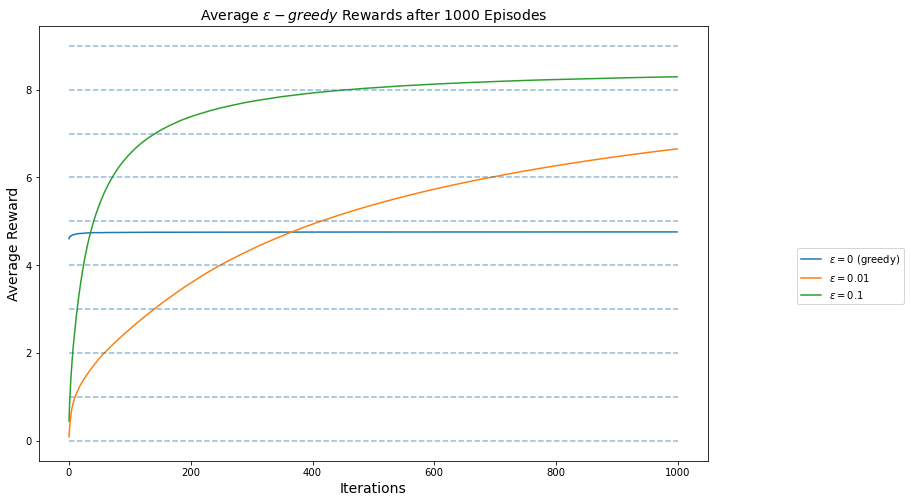

In [31]:
plt.figure(figsize=(12,8))
plt.plot(eps_0_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_01_rewards, label="$\epsilon=0.01$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
for i in range(k):
    plt.hlines(eps_0.mu[i], xmin=0, xmax=iters, alpha=0.5, linestyle="--")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Average Reward", fontsize=14)
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes) + " Episodes", fontsize=14)
plt.show()

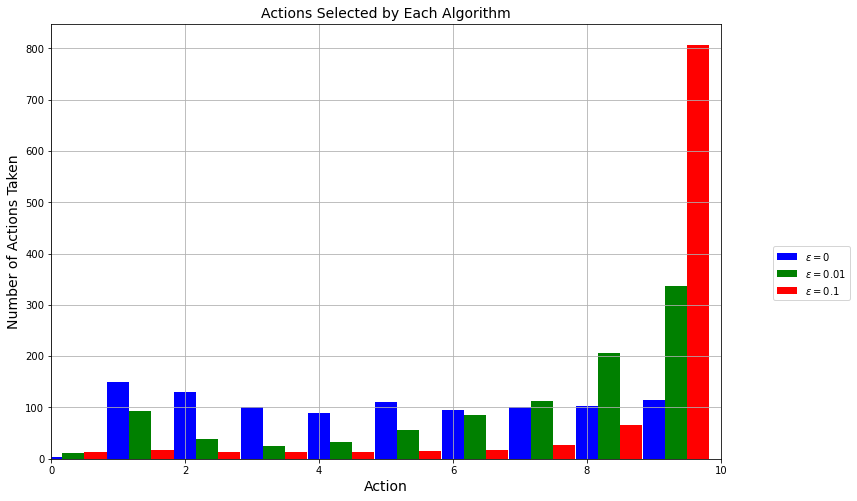

Percentage of actions selected:


,a = 0,a = 1,a = 2,a = 3,a = 4,a = 5,a = 6,a = 7,a = 8,a = 9
$\epsilon=0$,0.3861,15.0054,13.1096,10.0989,9.0000,11.0000,9.6000,10.0000,10.3000,11.5000
$\epsilon=0.01$,1.1954,9.2920,3.9488,2.4039,3.3618,5.5498,8.5276,11.3045,20.6739,33.7423
$\epsilon=0.1$,1.2798,1.6397,1.2775,1.2696,1.2555,1.5023,1.7581,2.7232,6.5767,80.7176


In [32]:
bins = np.linspace(0, k-1, k)

plt.figure(figsize=(12,8))
plt.bar(bins, eps_0_selection, width = 0.33, color='b', label="$\epsilon=0$")
plt.bar(bins+0.33, eps_01_selection, width=0.33, color='g', label="$\epsilon=0.01$")
plt.bar(bins+0.66, eps_1_selection, width=0.33, color='r', label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlim([0,k])
plt.title("Actions Selected by Each Algorithm", fontsize=14)
plt.xlabel("Action", fontsize=14)
plt.ylabel("Number of Actions Taken", fontsize=14)
plt.grid()
plt.show()

opt_per = np.array([eps_0_selection, eps_01_selection, eps_1_selection]) / iters * 100
df = pd.DataFrame(opt_per, index=['$\epsilon=0$', '$\epsilon=0.01$', '$\epsilon=0.1$'], columns=["a = " + str(x) for x in range(0, k)])
print("Percentage of actions selected:")
df

## $\epsilon$-Decay 전략
- $\epsilon$-greey는 얼마나 많은 예시를 보든 간에 random noise를 계속 포함 -> 명백한 약점을 보인다
- $\epsilon$-Decay는 매 step마다 exploration의 확률을 ㄱ마소한다

    $\epsilon(n)=\frac{1}{1+n\beta}$
    - $\beta<1$: scaling factor -> 알고리즘이 탐색할 수 있는 충분한 기회를 갖도록 scaling 비율을 줄인다
    - 또한 분모에 1을 더함으로써 무한대가 나타나지 않도록 방지

In [36]:
class eps_decay_bandit:
    '''
    epsilon-decay k-bandit problem
    
    Inputs
    =====================================================
    k: number of arms (int)
    iters: number of steps (int)
    mu: set the average rewards for each of the k-arms.
        Set to "random" for the rewards to be selected from
        a normal distribution with mean = 0. 
        Set to "sequence" for the means to be ordered from 
        0 to k-1.
        Pass a list or array of length = k for user-defined
        values.
    '''
    
    def __init__(self, k, iters, mu='random'):
        # Number of arms
        self.k = k
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 0
        # Step count for each arm
        self.k_n = np.zeros(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)
        
        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages            
            self.mu = np.array(mu)
        elif mu == 'random':
            # Draw means from probability distribution
            self.mu = np.random.normal(0, 1, k)
        elif mu == 'sequence':
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k-1, k)
        
    def pull(self):
        # Generate random number
        p = np.random.rand()
        if p < 1 / (1 + self.n / self.k): # beta = 1/k
            # randomly select an action
            a = np.random.choice(self.k)
        else:
            # Take greedy action
            a = np.argmax(self.k_reward)
            
        reward = np.random.normal(self.mu[a], 1)
        
        # Update counts
        self.n += 1
        self.k_n[a] += 1
        
        # Update total
        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.n
        
        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (reward - self.k_reward[a]) / self.k_n[a]
        
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward # iter 반복할 때마다 그때의 평균 보상 저장
            
    def reset(self):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(k)
        

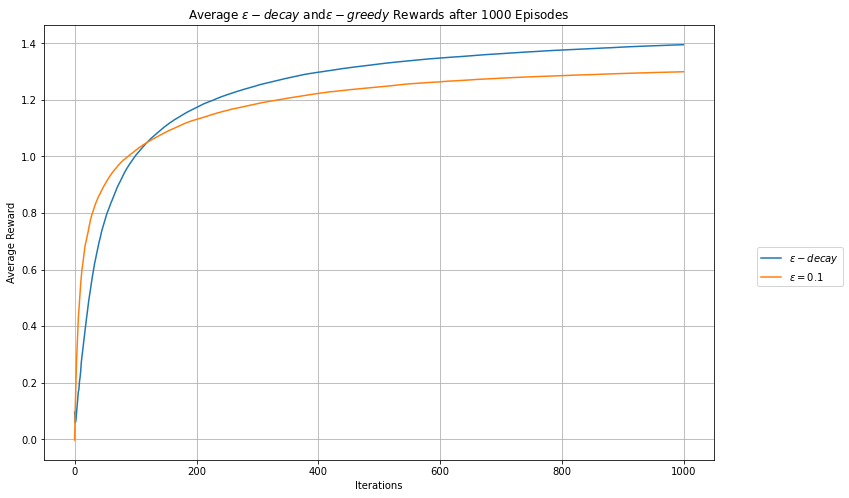

In [37]:
k = 10
iters = 1000

eps_decay_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)

episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    eps_decay = eps_decay_bandit(k, iters) # mu='random'
    eps_1 = eps_bandit(k, 0.1, iters, eps_decay.mu.copy())
    
    # Run experiments
    eps_decay.run()
    eps_1.run()
    
    # Update long-term averages
    eps_decay_rewards = eps_decay_rewards + (
        eps_decay.reward - eps_decay_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.reward - eps_1_rewards) / (i + 1)
    
plt.figure(figsize=(12,8))
plt.plot(eps_decay_rewards, label="$\epsilon-decay$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-decay$ and" + 
    "$\epsilon-greedy$ Rewards after " 
    + str(episodes) + " Episodes")
plt.grid()
plt.show()

## Optimistic Initial Value
- explore-exploit 딜레마의 균형을 맞추는 방법
- 위에서 정의한 `eps_bandit` 클래스에 $\epsilon=0$으로 준 다음 초기값을 높게 설정한다
- 또한 각 arm의 pull count의 초기값도 0이 아닌 1로 설정 => 약간 느리게 수렴하면서 좋은 탐색을 하도록


In [39]:
k = 10
iters = 1000

oiv_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)

# Select initial values
oiv_init = np.repeat(5., k)

episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    oiv_bandit = eps_bandit(k, 0, iters)
    oiv_bandit.k_reward = oiv_init.copy() # change 
    oiv_bandit.k_n = np.ones(k) # change
    eps_decay = eps_decay_bandit(k, iters, oiv_bandit.mu.copy())
    eps_1 = eps_bandit(k, 0.1, iters, oiv_bandit.mu.copy())
    
    # Run experiments
    oiv_bandit.run()
    eps_decay.run()
    eps_1.run()
    
    # Update long-term averages
    oiv_rewards = oiv_rewards + (oiv_bandit.reward - oiv_rewards) / (i + 1)
    eps_decay_rewards = eps_decay_rewards + (eps_decay.reward - eps_decay_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (eps_1.reward - eps_1_rewards) / (i + 1)

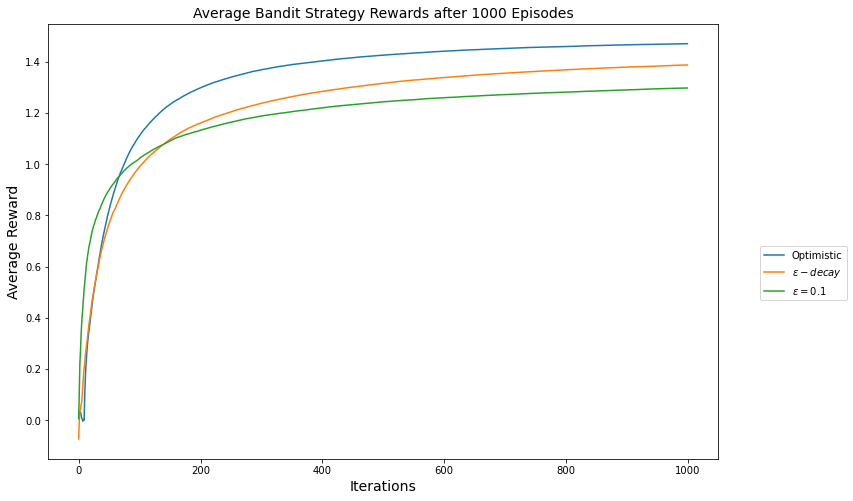

In [42]:
plt.figure(figsize=(12,8))
plt.plot(oiv_rewards, label="Optimistic")
plt.plot(eps_decay_rewards, label="$\epsilon-decay$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Average Reward", fontsize=14)
plt.title("Average Bandit Strategy Rewards after " + str(episodes) + " Episodes", fontsize=14)
plt.show()

In [43]:
df = pd.DataFrame({"number of selections": oiv_bandit.k_n - 1, "actual reward": oiv_bandit.mu, "estimated reward": oiv_bandit.k_reward})
df = df.applymap(lambda x: np.round(x, 2))
df['number of selections'] = df['number of selections'].astype('int')
df

,number of selections,actual reward,estimated reward
0,2,0.23,2.00
1,3,0.03,1.62
2,2,-0.89,1.97
3,2,-0.11,1.56
4,2,0.62,1.42
5,979,2.14,2.17
6,2,-0.04,1.70
7,1,0.63,1.95
8,5,1.11,2.03
9,2,-0.01,1.77


5번 arm을 제외하고는 실제 reward와 추정된 reward가 많이 차이남 